# About this kernel

The goal is to:
* Investigate the problem of null masks by exploring the distribution of NaN per image.
* Reduce image size to 224x224 for simpler models.
* Create a lightweight CNN to predict if a certain image has no defect (i.e., it has 4 missing masks). This will be useful in order to reduce the computation power needed to train a segmentation model (e.g. Mask R-CNN), since we can immediately discard the image with 4 missing masks.

We are using DenseNet and not MobileNet model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import json

import cv2
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
import tensorflow as tf
from tqdm import tqdm

Using TensorFlow backend.


In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/kaggle/train.csv')

print(train_df.shape)
train_df.head()

(7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
submission_df = pd.read_csv('/content/drive/My Drive/kaggle_unet/sample_submission_validation.csv')
print(submission_df.shape)
submission_df.head()

(1001, 3)


,ImageId,EncodedPixels,ClassId
0,242894fc4.jpg,1 409600,0
1,2434f1395.jpg,1 409600,0
2,24528b550.jpg,1 409600,0
3,2453b68e2.jpg,1 409600,0
4,2467e2b6e.jpg,1 409600,0


In [ ]:
unique_test_images = submission_df['ImageId'].unique()
unique_test_images

array(['242894fc4.jpg', '2434f1395.jpg', '24528b550.jpg', ...,
       '4c353fd1a.jpg', '4c36590af.jpg', '4c3afd528.jpg'], dtype=object)

# EDA

This EDA will mainly focus on detecting how the null masks are distributed. We will keep track of the number of missing masks for each image.

In [ ]:
train_df['isNan'] = pd.isna(train_df['EncodedPixels'])
train_df.head()

#We created isNan for the images which do not have any encodedpixels

,ImageId,ClassId,EncodedPixels,isNan
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,False
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,False
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,False
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,False
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,False


In [ ]:
train_nan_df = train_df.groupby(by='ImageId', axis=0).agg('sum')
train_nan_df.reset_index(inplace=True)
train_nan_df.rename(columns={'isNan': 'missingCount'}, inplace=True)
train_nan_df['missingCount'] = train_nan_df['missingCount'].astype(np.int32)
train_nan_df['allMissing'] = (train_nan_df['missingCount'] == 4).astype(int)

train_nan_df.head()

,ImageId,ClassId,missingCount,allMissing
0,0002cc93b.jpg,1,0,0
1,0007a71bf.jpg,3,0,0
2,000a4bcdd.jpg,1,0,0
3,000f6bf48.jpg,4,0,0
4,0014fce06.jpg,3,0,0


In [ ]:
test_nan_df = pd.DataFrame(unique_test_images, columns=['ImageId'])
print(test_nan_df.shape)
test_nan_df.head()

(1001, 1)


,ImageId
0,242894fc4.jpg
1,2434f1395.jpg
2,24528b550.jpg
3,2453b68e2.jpg
4,2467e2b6e.jpg


0    6666
Name: missingCount, dtype: int64

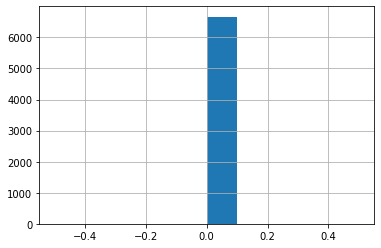

In [ ]:
train_nan_df['missingCount'].hist()
train_nan_df['missingCount'].value_counts()

#6666 images with 0 missing features

# Reducing Image Size

In [ ]:
def load_img(code, base, resize=False):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (256, 256))
    
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
#run this krutika
#to create custom validation folder using sample_submission_validation.csv
validation_path = '/content/drive/My Drive/kaggle_unet/step1/validation'
validate_path(validation_path)

#finding the submission images in train
for code in tqdm(submission_df['ImageId']):
    img = load_img(
        code,
        base='/content/drive/My Drive/kaggle/train_images'
    )
    path = code.replace('.jpg', '')
    cv2.imwrite(f'{validation_path}/{path}.jpg', img)


100%|██████████| 1001/1001 [05:48<00:00,  2.87it/s]


In [ ]:
'''
train_path = '/content/drive/My Drive/kaggle_unet/step1/train'
validate_path(train_path)

for code in tqdm(train_nan_df['ImageId']):
    img = load_img(
        code,
        base='/content/drive/My Drive/kaggle/train_images'
    )
    path = code.replace('.jpg', '')
    cv2.imwrite(f'{train_path}/{path}.png', img)
'''

"\ntrain_path = '/content/drive/My Drive/kaggle_unet/step1/train'\nvalidate_path(train_path)\n\nfor code in tqdm(train_nan_df['ImageId']):\n    img = load_img(\n        code,\n        base='/content/drive/My Drive/kaggle/train_images'\n    )\n    path = code.replace('.jpg', '')\n    cv2.imwrite(f'{train_path}/{path}.png', img)\n"

In [ ]:
train_nan_df['ImageId'] = train_nan_df['ImageId'].apply(
    lambda x: x.replace('.jpg', '.png')
)

# Modelling

In [ ]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
        validation_split=0.15
    )

def create_test_gen():
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_nan_df,
        directory='/content/drive/My Drive/kaggle_unet/step1/validation',#change this to validation_images
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        train_nan_df, 
        directory='/content/drive/My Drive/kaggle_unet_og/step1/train',
        x_col='ImageId', 
        y_col='allMissing', 
        class_mode='raw', #swami changed from other to raw
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()

Found 5667 validated image filenames.
Found 999 validated image filenames.
Found 0 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1001 invalid image filename(s) in x_col="ImageId". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
def build_model():
    densenet = DenseNet121(
        include_top=False,
        input_shape=(256,256,3),
        weights='/content/drive/My Drive/kaggle_unet/DenseNet-BC-121-32-no-top.h5'
    )
    
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Nadam(),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)              

In [ ]:
#These many stesp are required
total_steps = train_nan_df.shape[0] / BATCH_SIZE

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=total_steps * 0.85,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=40,
    callbacks=[checkpoint, reduce_lr]
)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [ ]:
test_gen

## Save results as CSV files

In [ ]:
model.load_weights('/content/drive/My Drive/kaggle_unet/step1/model.h5')
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

In [ ]:
test_nan_df

,ImageId
0,242894fc4.jpg
1,2434f1395.jpg
2,24528b550.jpg
3,2453b68e2.jpg
4,2467e2b6e.jpg
...,...
996,4c2bd254d.jpg
997,4c3100013.jpg
998,4c353fd1a.jpg
999,4c36590af.jpg


In [ ]:
y_test

[]

In [ ]:
test_nan_df['allMissing'] = y_test

#history_df.to_csv('history.csv', index=False)
#train_nan_df.to_csv('train_missing_count.csv', index=False)
test_nan_df.to_csv('validation_missing_count.csv', index=False)